### Authors:

Marek Szydłowski 136633<br>
Wojciech Tomczak 145467

Link to the source code: https://github.com/Vosloo/evolutionary-computation-labs

In [1]:
import sys
import functools
from pathlib import Path
import numpy as np
import pandas as pd


from multiprocessing import Pool
import pickle
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

In [2]:
module_path = Path.cwd().parent
if module_path not in sys.path:
    sys.path.append(str(module_path))

In [3]:
from src.tsp_problem import TSPProblem
from src.algorithms import Method
from src.visualization import Visualizer
from src.model import Grade, Run
from src.utils import get_edges

In [4]:
problem = TSPProblem(no_runs=100)

Loaded 4 instances: TSPA, TSPB, TSPC, TSPD
Available methods: ['RANDOM_SEQUENCE', 'NEAREST', 'GREEDY_CYCLE', 'GREEDY_REGRET', 'GREEDY_REGRET_WEIGHTED', 'LOCAL_SEARCH_STEEPEST_NODES_RANDOM', 'LOCAL_SEARCH_STEEPEST_NODES_HEURISTIC', 'LOCAL_SEARCH_STEEPEST_EDGES_RANDOM', 'LOCAL_SEARCH_STEEPEST_EDGES_HEURISTIC', 'LOCAL_SEARCH_GREEDY_NODES_RANDOM', 'LOCAL_SEARCH_GREEDY_NODES_HEURISTIC', 'LOCAL_SEARCH_GREEDY_EDGES_RANDOM', 'LOCAL_SEARCH_GREEDY_EDGES_HEURISTIC', 'LOCAL_SEARCH_CANDIDATES_RANDOM', 'LOCAL_SEARCH_CANDIDATES_HEURISTIC', 'LOCAL_SEARCH_MOVES_RANDOM', 'LOCAL_SEARCH_MSLS', 'LOCAL_SEARCH_ITERATIVE', 'LOCAL_SEARCH_LSN_NO_LS', 'LOCAL_SEARCH_LSN_WITH_LS', 'HYBRID_EVOLUTION_OPERATOR_1', 'HYBRID_EVOLUTION_OPERATOR_1_NO_LS', 'HYBRID_EVOLUTION_OPERATOR_2', 'HYBRID_EVOLUTION_OPERATOR_2_NO_LS']


In [5]:
items = [
    (("TSPD",), [Method.LOCAL_SEARCH_GREEDY_EDGES_RANDOM]),
    (("TSPD",), [Method.LOCAL_SEARCH_GREEDY_EDGES_RANDOM]),
    (("TSPD",), [Method.LOCAL_SEARCH_GREEDY_EDGES_RANDOM]),
    (("TSPD",), [Method.LOCAL_SEARCH_GREEDY_EDGES_RANDOM]),
    (("TSPD",), [Method.LOCAL_SEARCH_GREEDY_EDGES_RANDOM]),
    (("TSPD",), [Method.LOCAL_SEARCH_GREEDY_EDGES_RANDOM]),
    (("TSPD",), [Method.LOCAL_SEARCH_GREEDY_EDGES_RANDOM]),
    (("TSPD",), [Method.LOCAL_SEARCH_GREEDY_EDGES_RANDOM]),
    (("TSPD",), [Method.LOCAL_SEARCH_GREEDY_EDGES_RANDOM]),
    (("TSPD",), [Method.LOCAL_SEARCH_GREEDY_EDGES_RANDOM]),
]

# with Pool() as pool:
#     grades_tmp = pool.starmap(problem.run, items)

In [6]:
# pickle.dump(grades_tmp, open("grades_tspd.pkl", "wb"))

In [7]:
def multiprocessing_merge(path: str | Path) -> dict[str, dict[Method, Grade]]:
    _grades = pickle.load(open(path, "rb"))
    grades: dict[str, dict] = dict()

    # group grades by dataset and method
    for process in _grades:
        for k, v in process.items():
            if k not in grades:
                grades[k] = {}

            for kk, vv in v.items():
                if kk in grades[k]:
                    grades[k][kk].append(vv)
                else:
                    grades[k][kk] = [vv]

    # merge grades
    for k, v in grades.items():
        for kk, vv in v.items():
            if len(vv) == 1:
                grades[k][kk] = vv[0]
            else:
                merged_runs: list[Run] = []
                merged_best_run: Run = None
                merged_runtime: float = 0

                grade: Grade
                for grade in vv:
                    merged_runs.extend(grade.runs)
                    merged_runtime += grade._runtime
                    if merged_best_run is None or merged_best_run > grade.best_run:
                        merged_best_run = grade.best_run

                grades[k][kk] = Grade(kk.value.replace("_", " ").title(), merged_best_run, merged_runs)
                grades[k][kk].set_runtime(merged_runtime)

    return grades

In [8]:
grades_tspc = multiprocessing_merge("grades_tspc.pkl")
grades_tspd = multiprocessing_merge("grades_tspd.pkl")
grades = {"TSPC": grades_tspc["TSPC"], "TSPD": grades_tspd["TSPD"]}

In [9]:
for instance_name, instance_grades in grades.items():
    print(f"\n{instance_name}:")
    print("----")
    for method_name, grade in instance_grades.items():
        meth_name = method_name.value.replace("_", " ").title()
        print(f"{meth_name}: {grade}")


TSPC:
----
Local Search Greedy Edges Random: 
==================================== Grade =====================================
Method:                                 Local Search Greedy Edges Random
Best run id:                            180
Best run cost:                          28183
Best run distance:                      20341
Best run score:                         48524
Min score:                              48524
Avg score:                              51573
Max score:                              55161


TSPD:
----
Local Search Greedy Edges Random: 
==================================== Grade =====================================
Method:                                 Local Search Greedy Edges Random
Best run id:                            103
Best run cost:                          25066
Best run distance:                      20585
Best run score:                         45651
Min score:                              45651
Avg score:                              48583
Max

In [10]:
nodes = {
    instance_name: problem._get_nodes(instance)
    for instance_name, instance in problem.instances.items()
    if instance_name in ("TSPC", "TSPD")
}
visualizer = Visualizer(nodes)

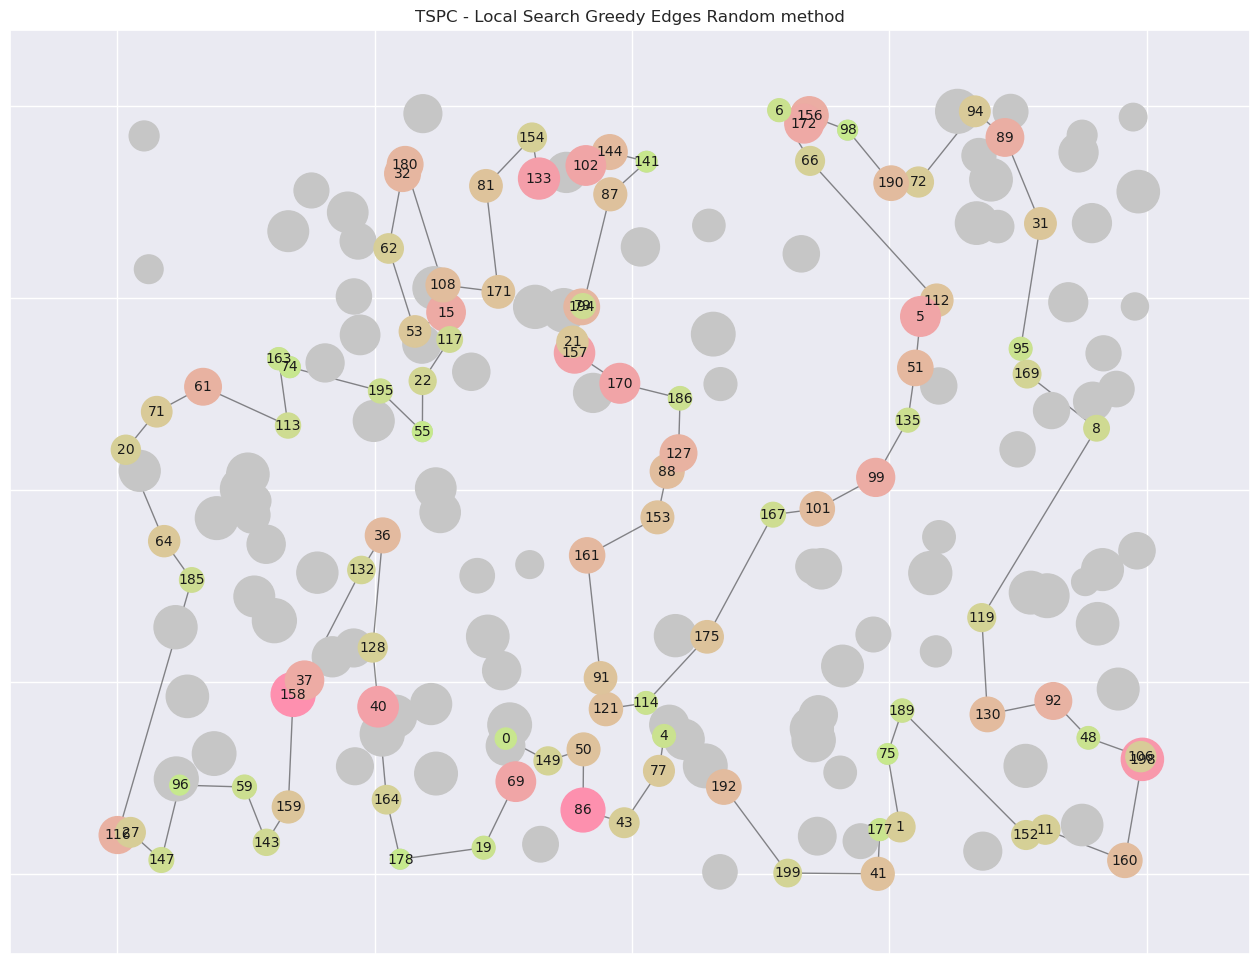

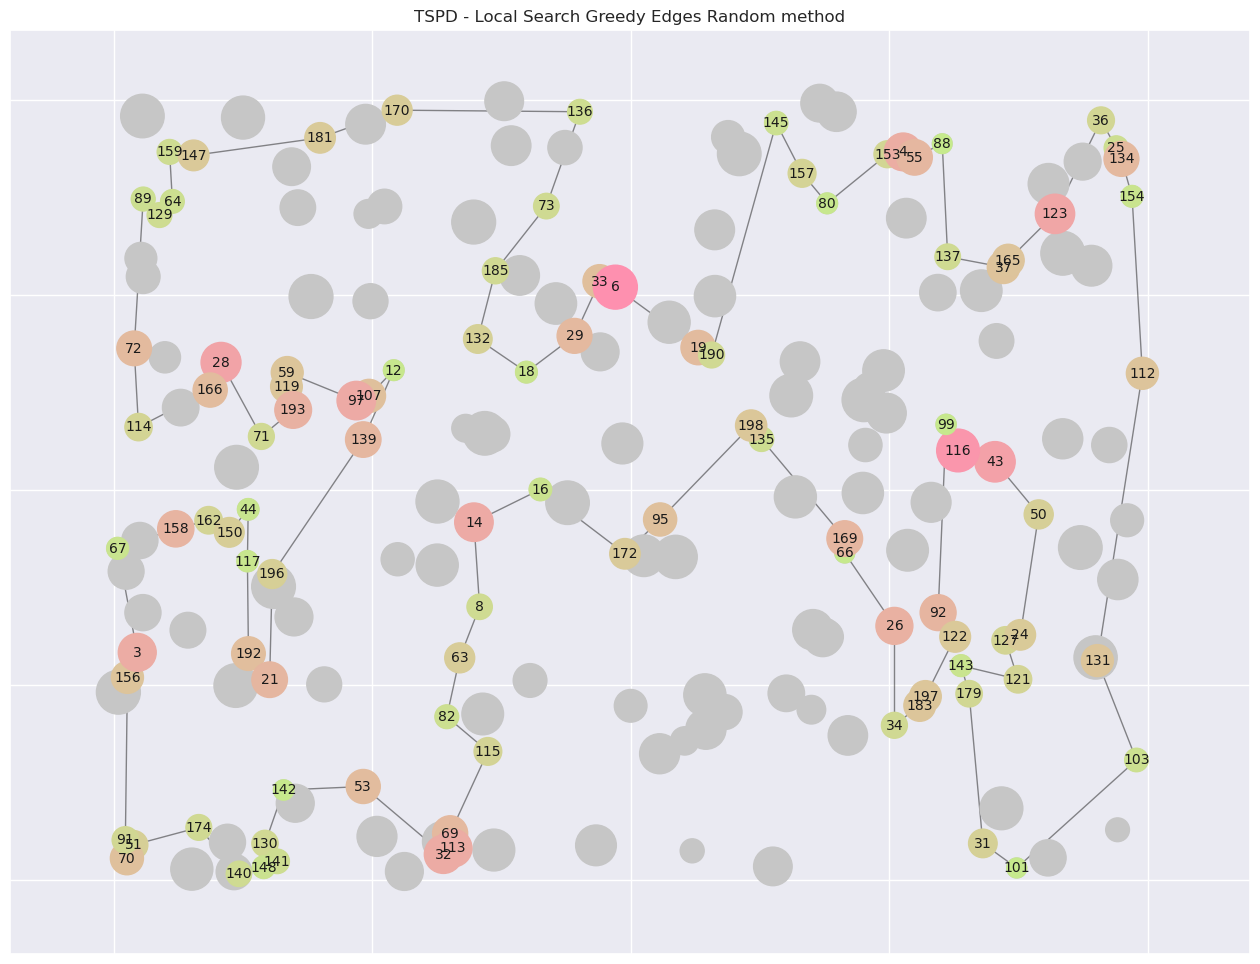

In [11]:
for instance_name, instance_grades in grades.items():
    for method_name, grade in instance_grades.items():
        visualizer.visualise_solution(grade, instance_name, method_name)

In [12]:
res = {}
for instance_name, instance_grades in grades.items():
    res[instance_name] = {}
    for method_name, grade in instance_grades.items():
        meth_name = method_name.value.replace("_", " ").title()
        res[instance_name][meth_name] = [grade.avg, grade.min, grade.max, *grade.runtime]

In [13]:
dfs = {}
for instance, methods in res.items():
    df = (
        pd.DataFrame.from_dict(
            methods,
            orient="index",
            columns=["Average Score", "Min Score", "Max Score", "Total runtime", "Per run runtime"],
        )
        .reset_index()
        .sort_values(by="Min Score")
        .reset_index(drop=True)
    )
    df.columns = [
        "Method",
        "Average Score",
        "Min Score",
        "Max Score",
        "Total runtime",
        "Per run runtime",
    ]
    df.index.name = instance
    dfs[instance] = df

In [14]:
for df in dfs.values():
    display(Markdown(df.to_markdown()))

|   TSPC | Method                           |   Average Score |   Min Score |   Max Score |   Total runtime |   Per run runtime |
|-------:|:---------------------------------|----------------:|------------:|------------:|----------------:|------------------:|
|      0 | Local Search Greedy Edges Random |           51573 |       48524 |       55161 |         75223.4 |           75.2234 |

|   TSPD | Method                           |   Average Score |   Min Score |   Max Score |   Total runtime |   Per run runtime |
|-------:|:---------------------------------|----------------:|------------:|------------:|----------------:|------------------:|
|      0 | Local Search Greedy Edges Random |           48583 |       45651 |       52441 |           62946 |            62.946 |

In [15]:
class Edge:
    def __init__(self, node1, node2):
        self.node1 = node1
        self.node2 = node2

    def __eq__(self, other):
        return (
            self.node1 == other.node1
            and self.node2 == other.node2
            or self.node1 == other.node2
            and self.node2 == other.node1
        )

    def __hash__(self):
        return hash(self.node1) + hash(self.node2) * 1337

In [16]:
def format_edges(edges):
    return [Edge(*edge) for edge in edges]

In [17]:
def _get_edges_similarity(pivot_run, run) -> float:
    return len(
        set(format_edges(get_edges(pivot_run.nodes))).intersection(
            set(format_edges(get_edges(run.nodes)))
        )
    ) / len(pivot_run.nodes)


def _get_nodes_similarity(pivot_run, run) -> float:
    return len(set(pivot_run.nodes).intersection(set(run.nodes))) / len(pivot_run.nodes)

In [18]:
def _remove_diagonal(A: np.array) -> np.array:
    return A[~np.eye(A.shape[0], dtype=bool)].reshape(A.shape[0], -1)

In [19]:
def messure_similarity(grade: Grade) -> tuple[np.ndarray, np.ndarray]:
    runs = grade.runs

    edge_similarity = []
    node_similarity = []

    for pivot_run in runs:
        edge_similarity.append([_get_edges_similarity(pivot_run, run) for run in runs])
        node_similarity.append([_get_nodes_similarity(pivot_run, run) for run in runs])

    return np.array(edge_similarity), np.array(node_similarity)

In [20]:
def _get_best_run_ind(grade: Grade) -> int:
    best_run_ind, best_run = 0, grade.runs[0]
    for i, run in enumerate(grade.runs):
        if run.score < best_run.score:
            best_run_ind, best_run = i, run
    return best_run_ind

In [21]:
def _plot_similarity(x: np.array, y: np.array, title: str, x_label: str, y_label: str) -> None:
    plt.figure(figsize=(10, 10))
    plt.scatter(x, y)
    corrcoef = np.corrcoef(x, y)[0, 1]
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    print(f"Correlation coefficient: {corrcoef:.2f}")

In [22]:
def visualize_similarity(grade: Grade):
    edge_similarity, node_similarity = messure_similarity(grade)
    runs_score = np.array([run.score for run in grade.runs])

    avg_edge_similarity = np.mean(_remove_diagonal(edge_similarity), axis=1)
    avg_node_similarity = np.mean(_remove_diagonal(node_similarity), axis=1)

    best_run_ind = _get_best_run_ind(grades["TSPC"][Method.LOCAL_SEARCH_GREEDY_EDGES_RANDOM])
    best_edge_similarity = edge_similarity[:, best_run_ind]
    best_node_similarity = node_similarity[:, best_run_ind]

    _plot_similarity(runs_score, avg_edge_similarity, "Average edge similarity", "Score", "Similarity")
    _plot_similarity(runs_score, avg_node_similarity, "Average node similarity", "Score", "Similarity")

    no_best_runs_score = np.delete(runs_score, best_run_ind)
    no_best_best_edge_similarity = np.delete(best_edge_similarity, best_run_ind)
    no_best_best_node_similarity = np.delete(best_node_similarity, best_run_ind)

    _plot_similarity(
        no_best_runs_score, no_best_best_edge_similarity, "Best edge similarity", "Score", "Similarity"
    )
    _plot_similarity(
        no_best_runs_score, no_best_best_node_similarity, "Best node similarity", "Score", "Similarity"
    )

## TSPC

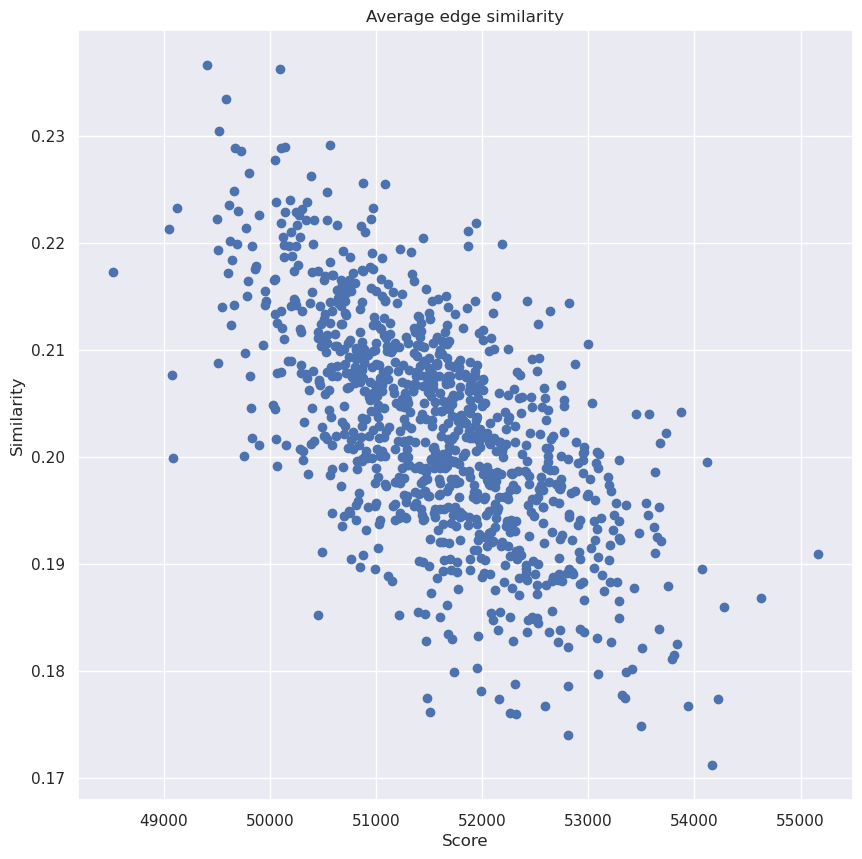

Correlation coefficient: -0.63


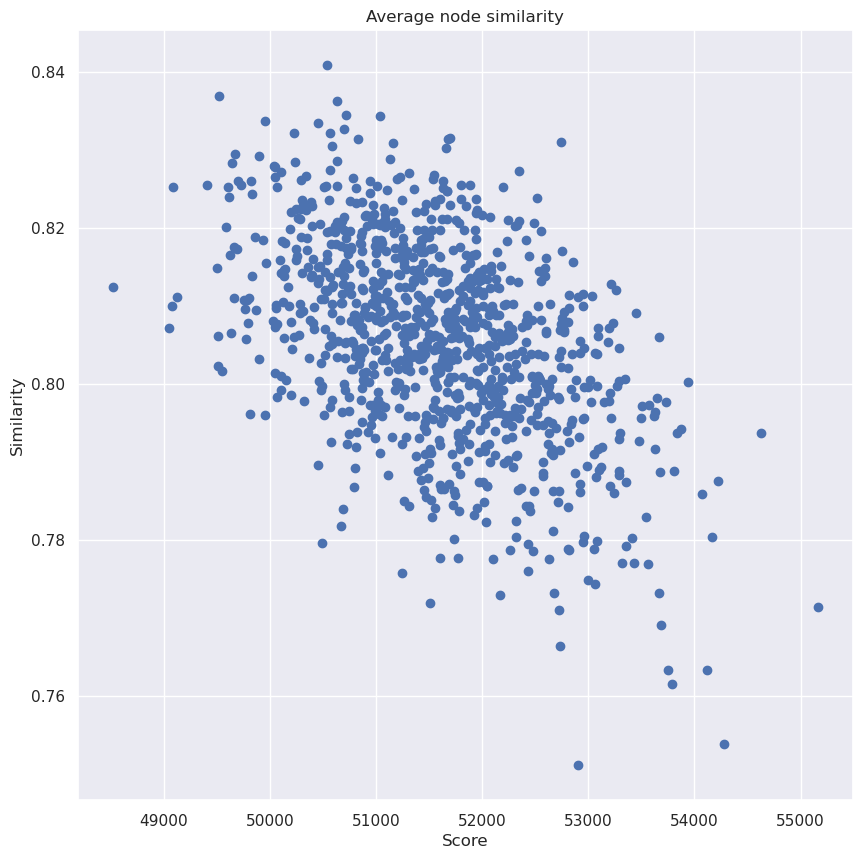

Correlation coefficient: -0.49


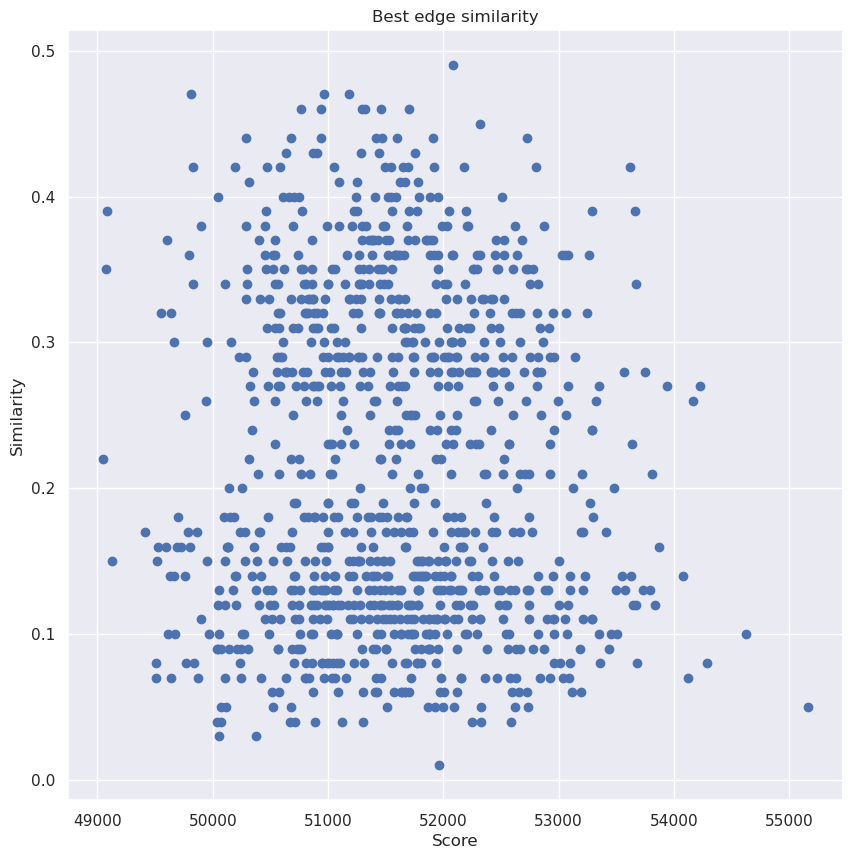

Correlation coefficient: -0.03


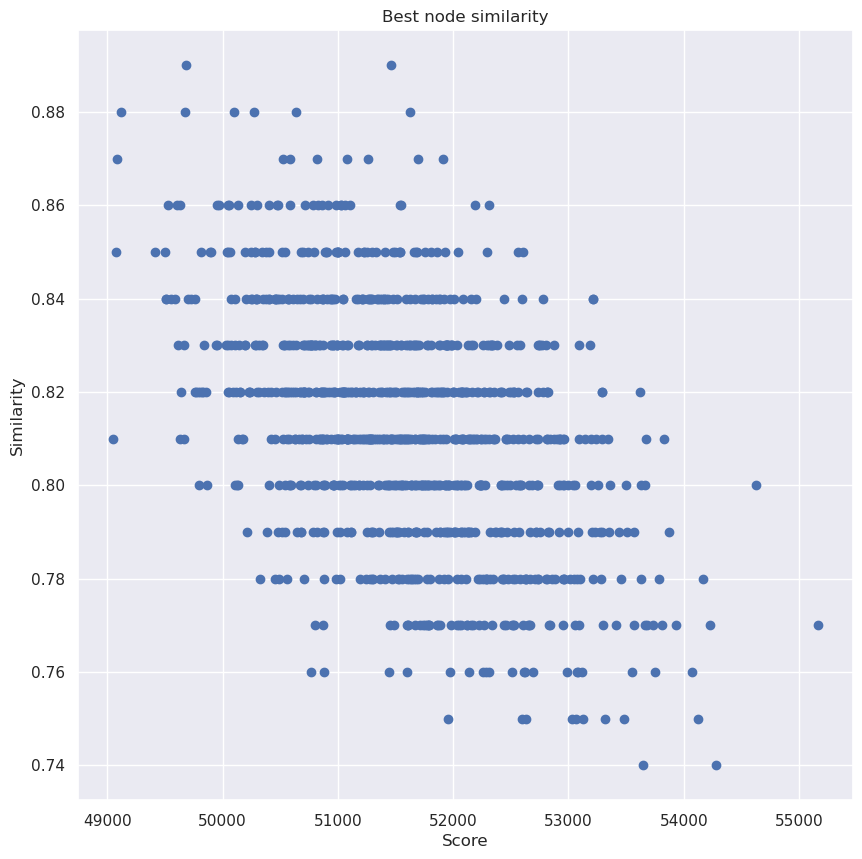

Correlation coefficient: -0.50


In [23]:
visualize_similarity(grades["TSPC"][Method.LOCAL_SEARCH_GREEDY_EDGES_RANDOM])

## TSPD

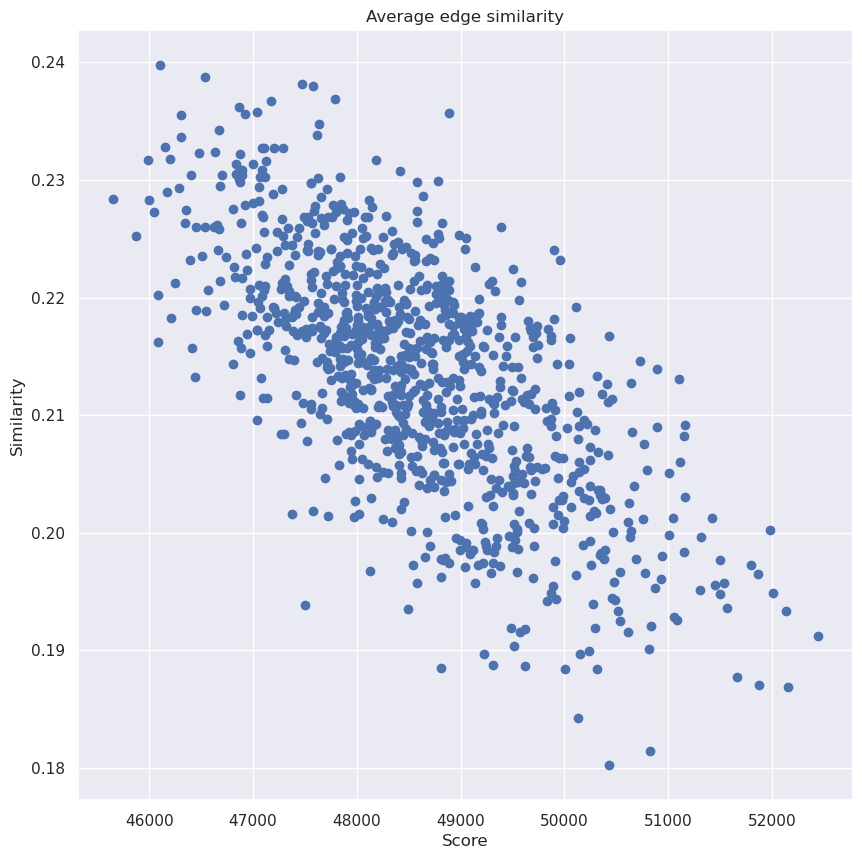

Correlation coefficient: -0.68


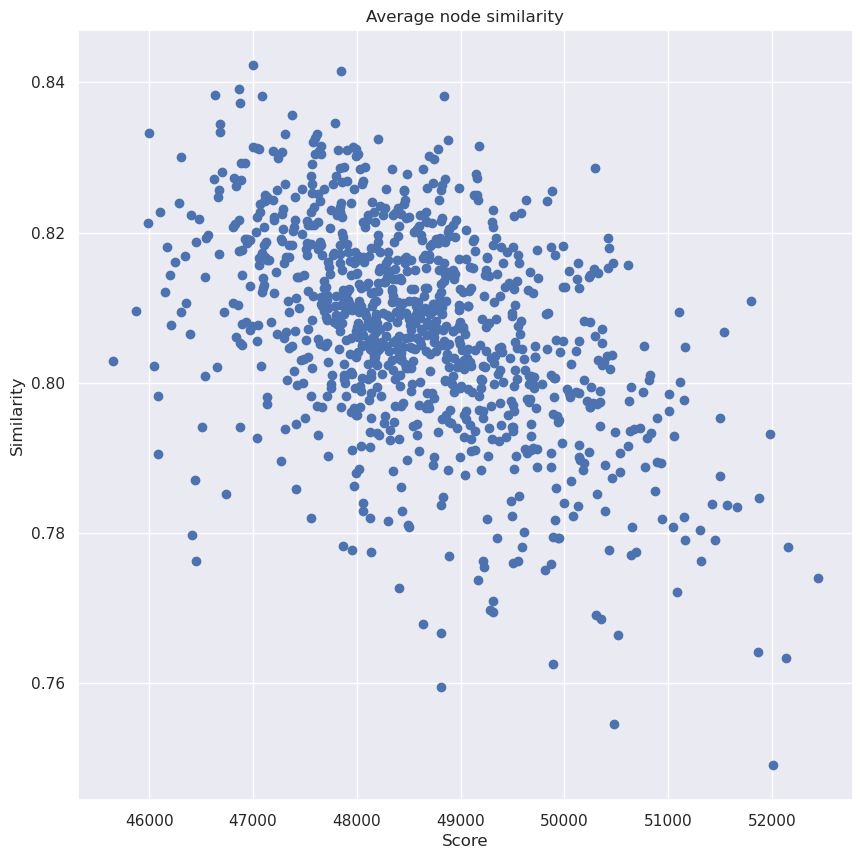

Correlation coefficient: -0.47


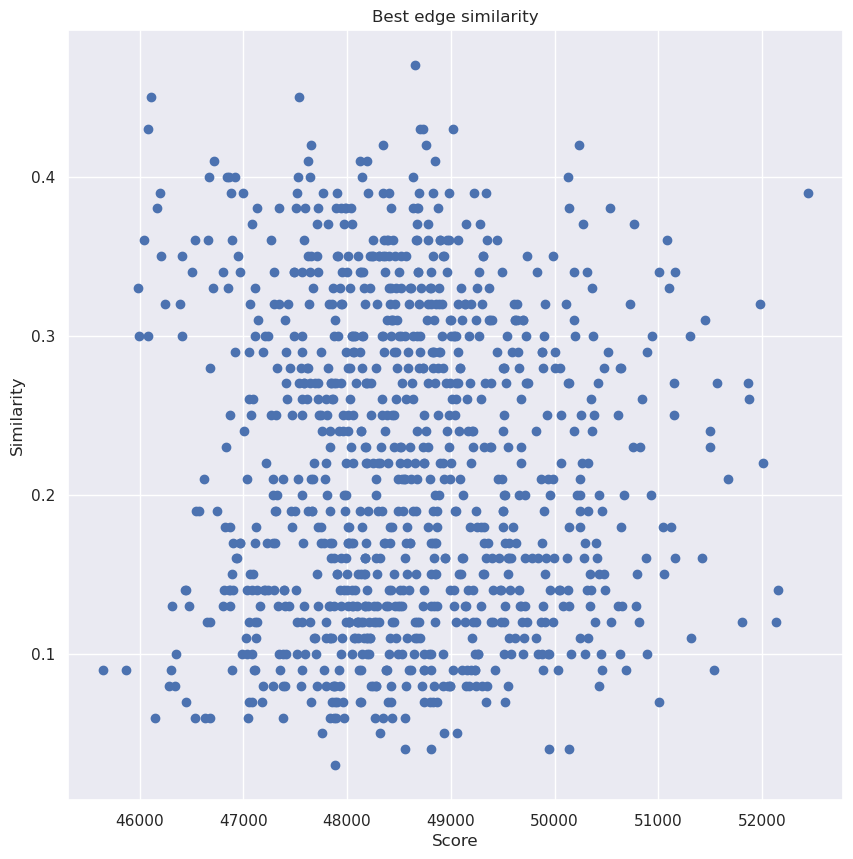

Correlation coefficient: -0.02


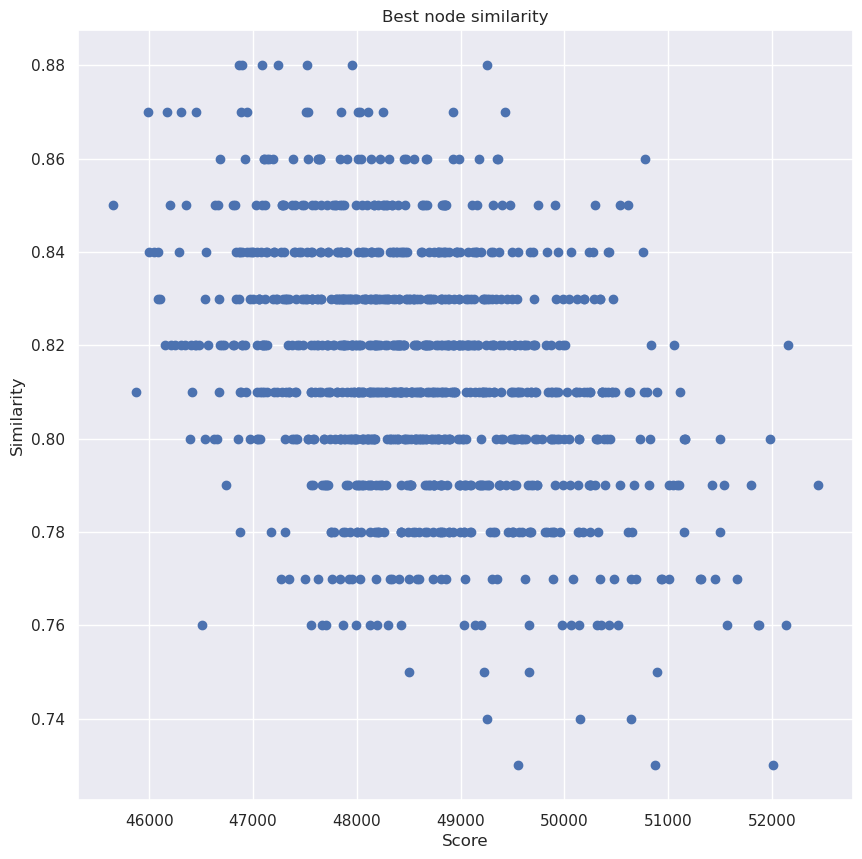

Correlation coefficient: -0.36


In [24]:
visualize_similarity(grades["TSPD"][Method.LOCAL_SEARCH_GREEDY_EDGES_RANDOM])

For both average edge and node similarity there is a clear pattern of rapidly declining similarity as score worsens (for both TSPC and TSPD).
Same cannot be said for best edge similarity where there is essentially no correlation. Finally in best node similarity correlation is present and evident same as in first case.